In [9]:
import os
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import anndata as ad
import lightning as L
from os.path import join
from modlyn.io.loading import read_lazy

import lamindb as ln

from modlyn.io.datamodules import ClassificationDataModule
from modlyn.models.linear import Linear
from modlyn.io.loading import read_lazy

In [10]:
store_path = Path("/home/ubuntu/tahoe100M_chunk_1")


In [15]:
adata = read_lazy(store_path)
var = pd.read_parquet("var_new.parquet")
print(var)
adata.var = var.reindex(adata.var.index)
# print(adata)

# adata.var = var

/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_ut

            feature_id feature_name
0      ENSG00000186092        OR4F5
1      ENSG00000284733       OR4F29
2      ENSG00000284662       OR4F16
3      ENSG00000187634       SAMD11
4      ENSG00000188976        NOC2L
...                ...          ...
19326  ENSG00000288702       UGT1A3
19327  ENSG00000288705       UGT1A5
19328  ENSG00000182484       WASH6P
19329  ENSG00000288622   PDCD6-AHRR
19330  ENSG00000285815  GET1-SH3BGR

[19331 rows x 2 columns]


In [16]:
adata.obs["y"] = adata.obs["cell_line"].astype("category").cat.codes.to_numpy().astype("i8")

In [17]:
adata_train = adata[:800000]
adata_val = adata[800000:]

datamodule = ClassificationDataModule(
    adata_train=adata_train,
    adata_val=adata_val,
    label_column="y",
    train_dataloader_kwargs={
        "batch_size": 2048,
        "drop_last": True,
    },
    val_dataloader_kwargs={
        "batch_size": 2048,
        "drop_last": False,
    },
)

In [18]:
linear = Linear(
    n_genes=adata.n_vars,
    n_covariates=adata.obs["y"].nunique(),
    learning_rate=1e-2,
)

In [19]:
trainer = L.Trainer(
    max_epochs=3,
    log_every_n_steps=100,
    max_steps=3000,  # only fit a few steps for the sake of this tutorial
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model=linear, datamodule=datamodule)


  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | linear        | Linear           | 958 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
958 K     Trainable params
0         Non-trainable params
958 K     Total params
3.836     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                                                                                                                                     | 0/? [00:00<?, ?it/s]

/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:11<00:00,  2.96it/s, v_num=2]
Validation: |                                                                                                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:10<00:00,  3.00it/s, v_num=2]
Validation: |                                                                                                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:48<00:00,  2.31it/s, v_num=2]


## Quick analysis

Extracting gene names from adata.var...
adata.var columns: ['feature_id', 'feature_name']
adata.var shape: (19177, 2)
adata.var preview:
        feature_id feature_name
0  ENSG00000186092        OR4F5
1  ENSG00000284733       OR4F29
2  ENSG00000284662       OR4F16
3  ENSG00000187634       SAMD11
4  ENSG00000188976        NOC2L
Using 'feature_name': ['OR4F5', 'OR4F29', 'OR4F16', 'SAMD11', 'NOC2L']


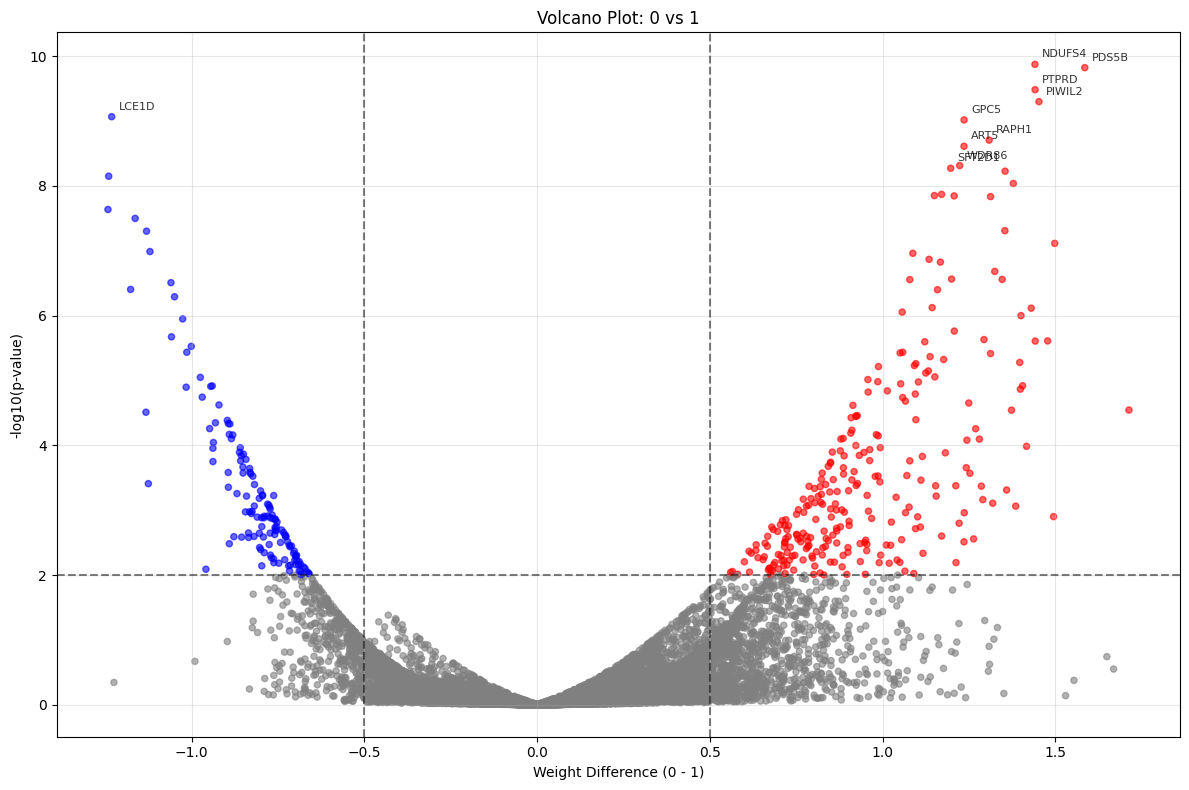

 Creating scanpy dotplot with model weights...
Top 20 genes: ['CYP11A1', 'ITGAE', 'PTPN9', 'TNS4', 'CXCL9']...
Created weight AnnData: AnnData object with n_obs × n_vars = 50 × 20
    obs: 'class', 'group'
    var: 'gene_name', 'original_index'


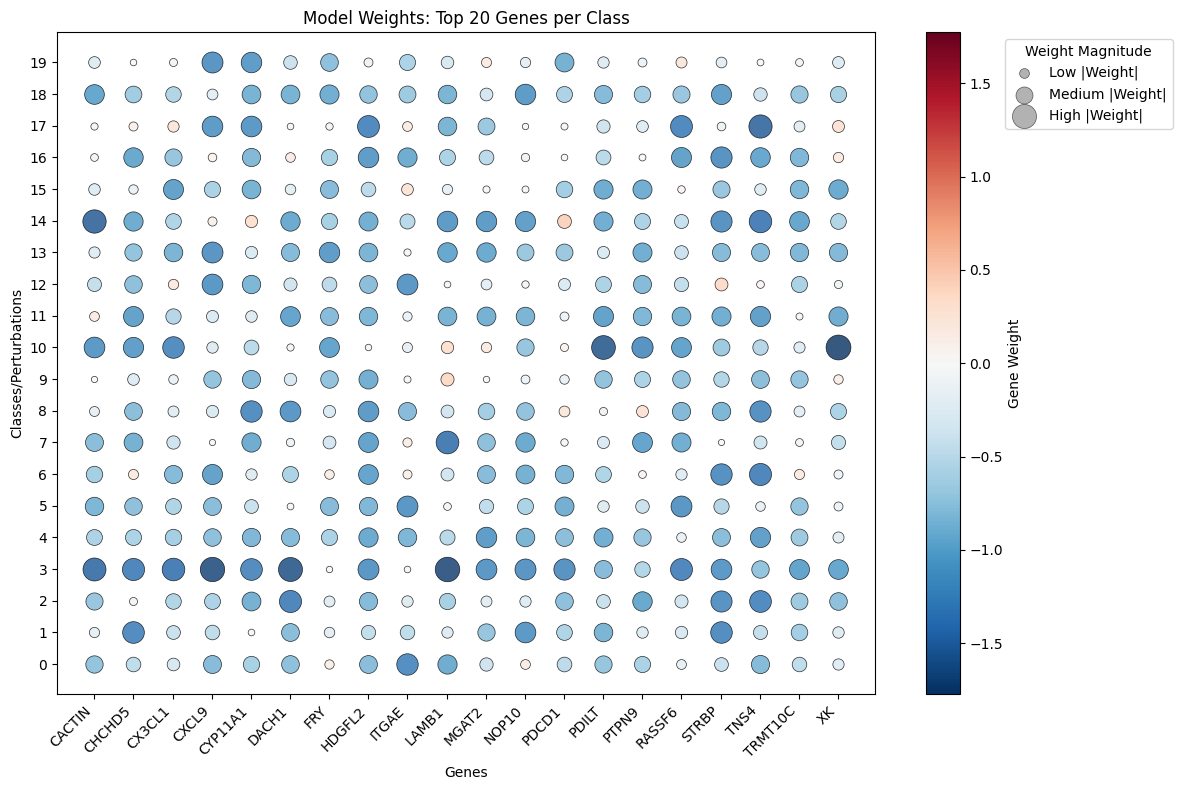

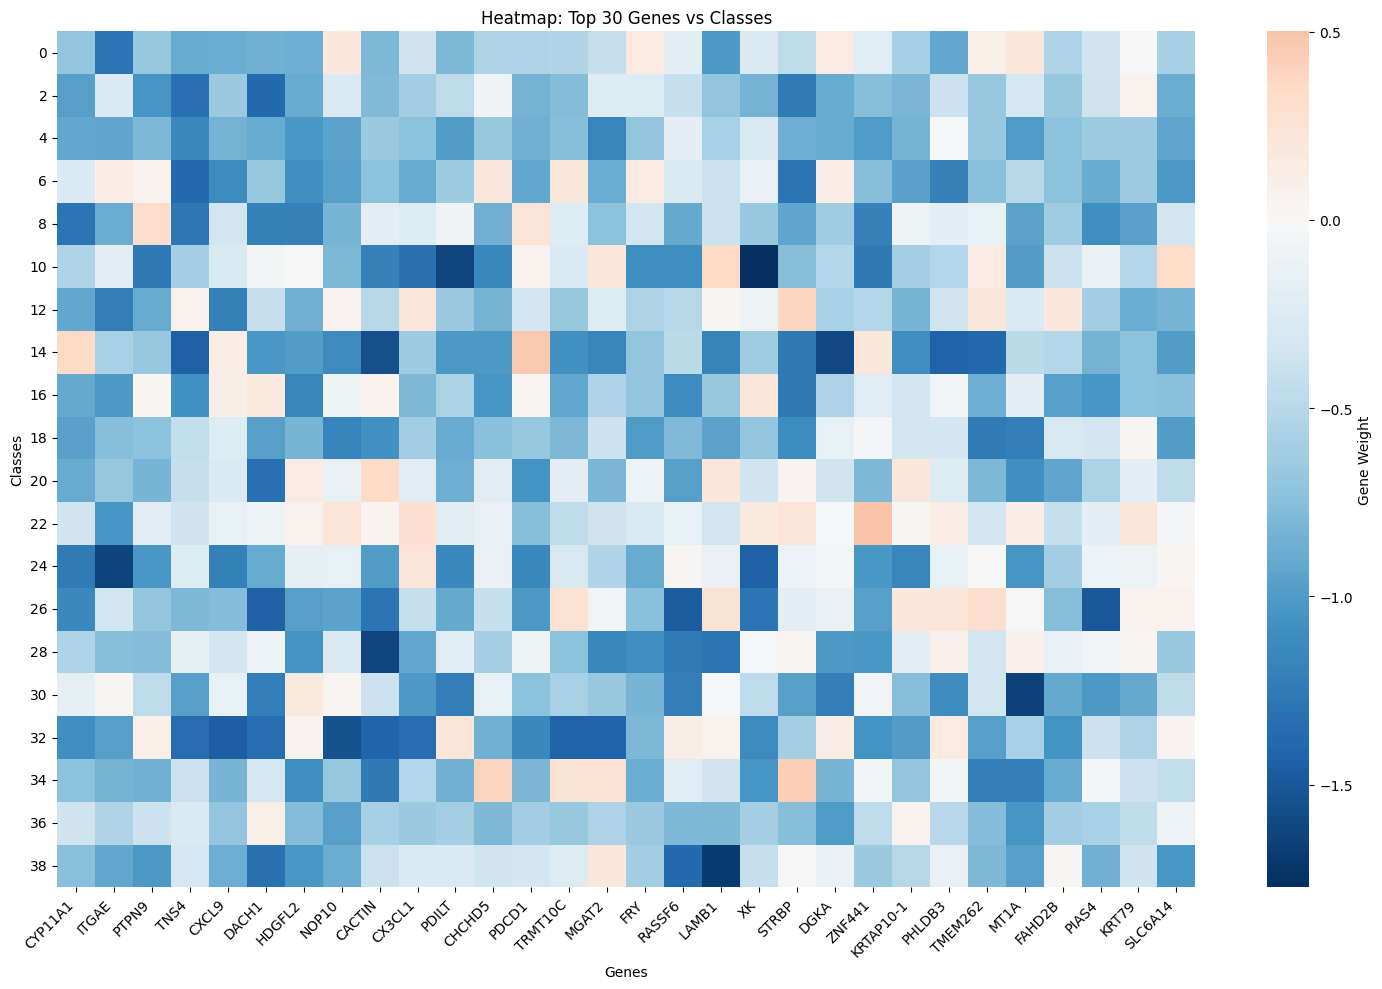


CONFOUNDER vs BIOLOGICAL ANALYSIS
Potential confounders: ['sample', 'sublibrary', 'BARCODE', 'plate']
Biological variables: ['drugname_drugconc', 'drug', 'cell_line']

Confounders:
  sample: 1050 unique values
  sublibrary: 260 unique values
  BARCODE: 906109 unique values
  plate: 14 unique values

Biological:
  drugname_drugconc: 910 unique values
  drug: 370 unique values
  cell_line: 50 unique values
Model has 50 classes and 19177 genes
Average weight magnitude: 0.1476
Most variable class: 1

Top 10 most important genes (with real names):
   1. CYP11A1: 0.7255
   2. ITGAE: 0.6841
   3. PTPN9: 0.6837
   4. TNS4: 0.6822
   5. CXCL9: 0.6751
   6. DACH1: 0.6740
   7. HDGFL2: 0.6674
   8. NOP10: 0.6642
   9. CACTIN: 0.6620
  10. CX3CL1: 0.6478


In [24]:
import importlib
import LinearModuleAnalyzer
importlib.reload(LinearModuleAnalyzer)

from LinearModuleAnalyzer import quick_analysis_with_scanpy_dotplot, full_analysis

# analyzer, weight_adata, df = quick_analysis_with_scanpy_dotplot(linear, adata, datamodule)
results = full_analysis(linear, adata, datamodule)

# Uncertainty scores

 COMPARING UNCERTAINTY ESTIMATION METHODS
Computing Fisher Information Matrix standard errors...
 Fisher Information standard errors computed
Computing uncertainty using sklearn LogisticRegression...
 sklearn-based standard errors computed
Computing bootstrap standard errors (n_bootstrap=20)...
 Bootstrap completed with 20 successful iterations
 Using sklearn-based standard errors
Significant weights (p < 0.05): 36731 / 958850
 All plots saved as PNG files


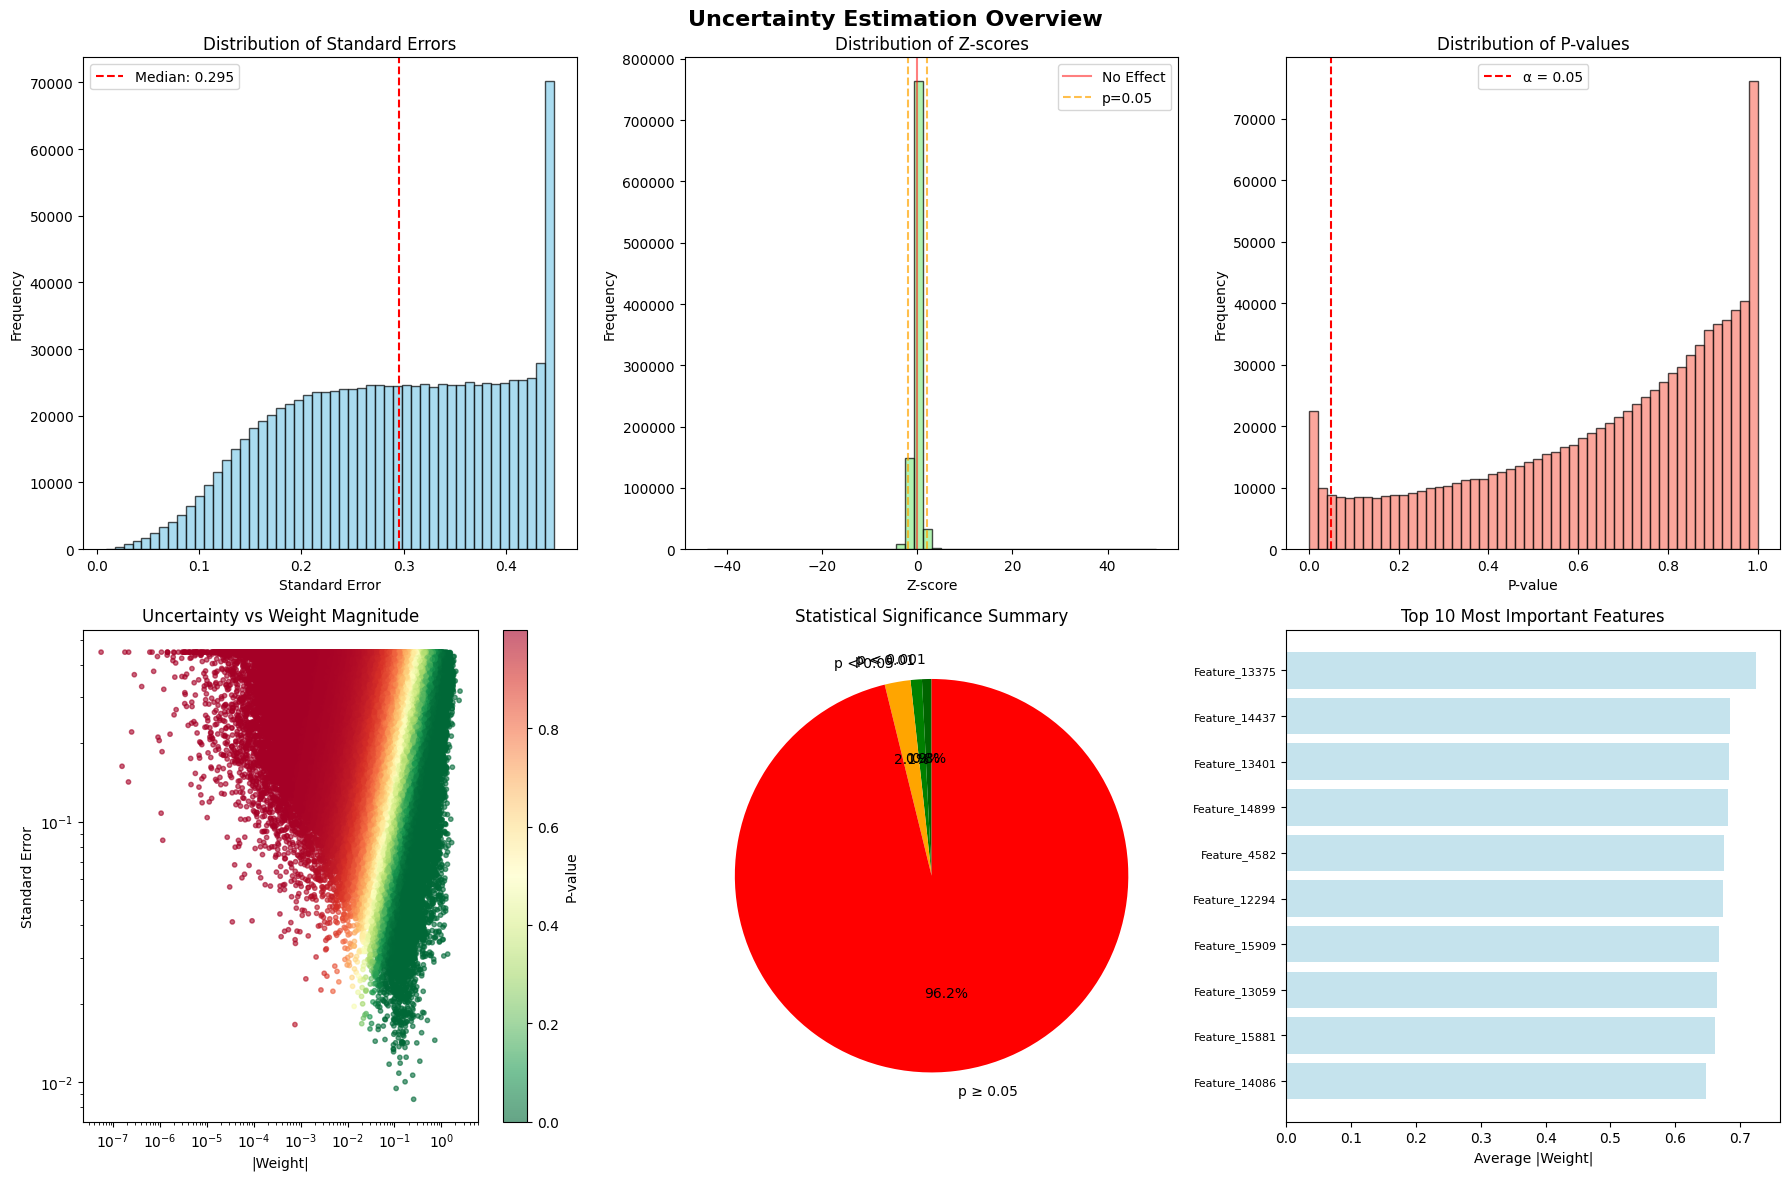

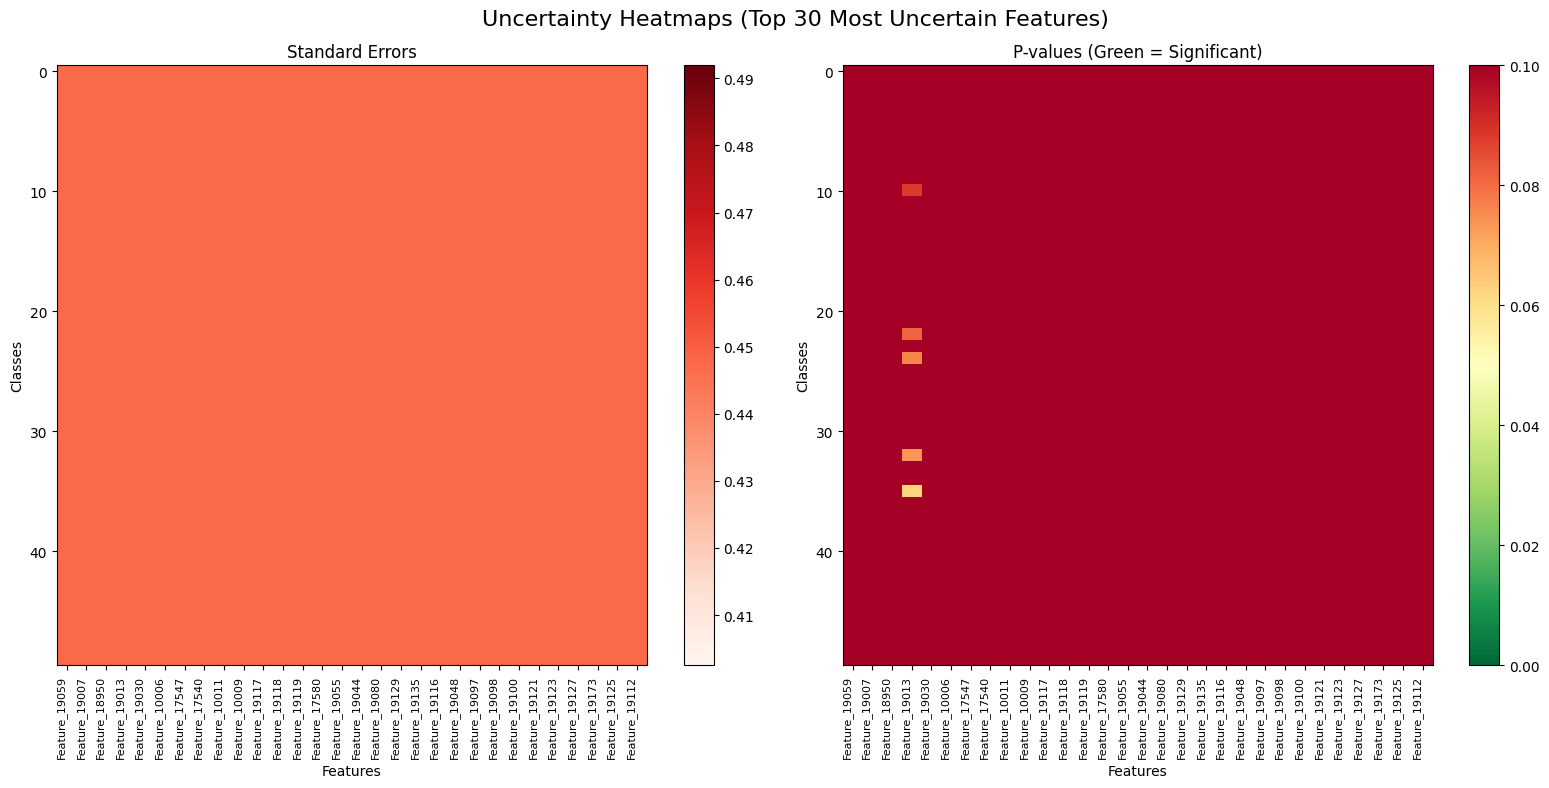

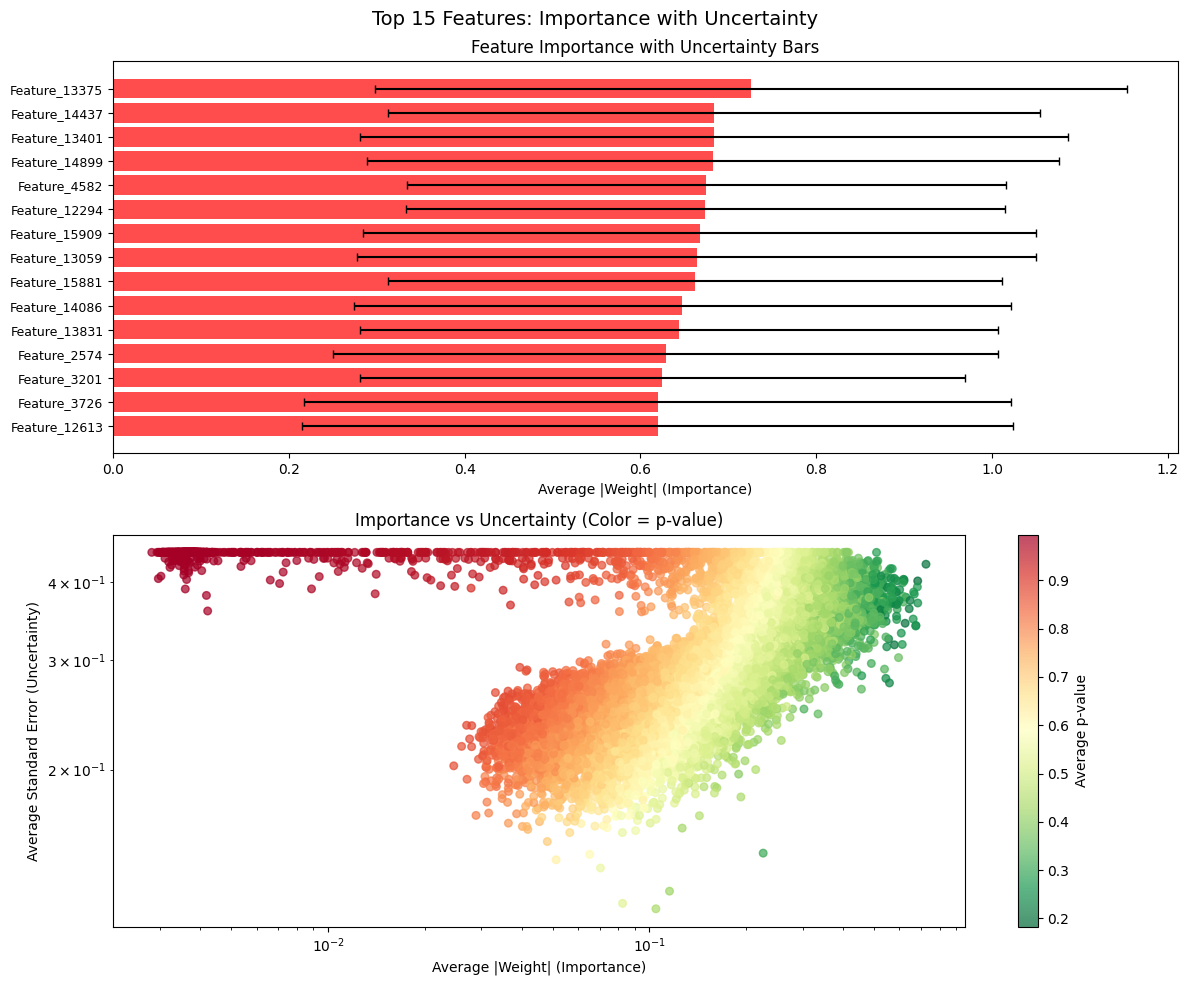

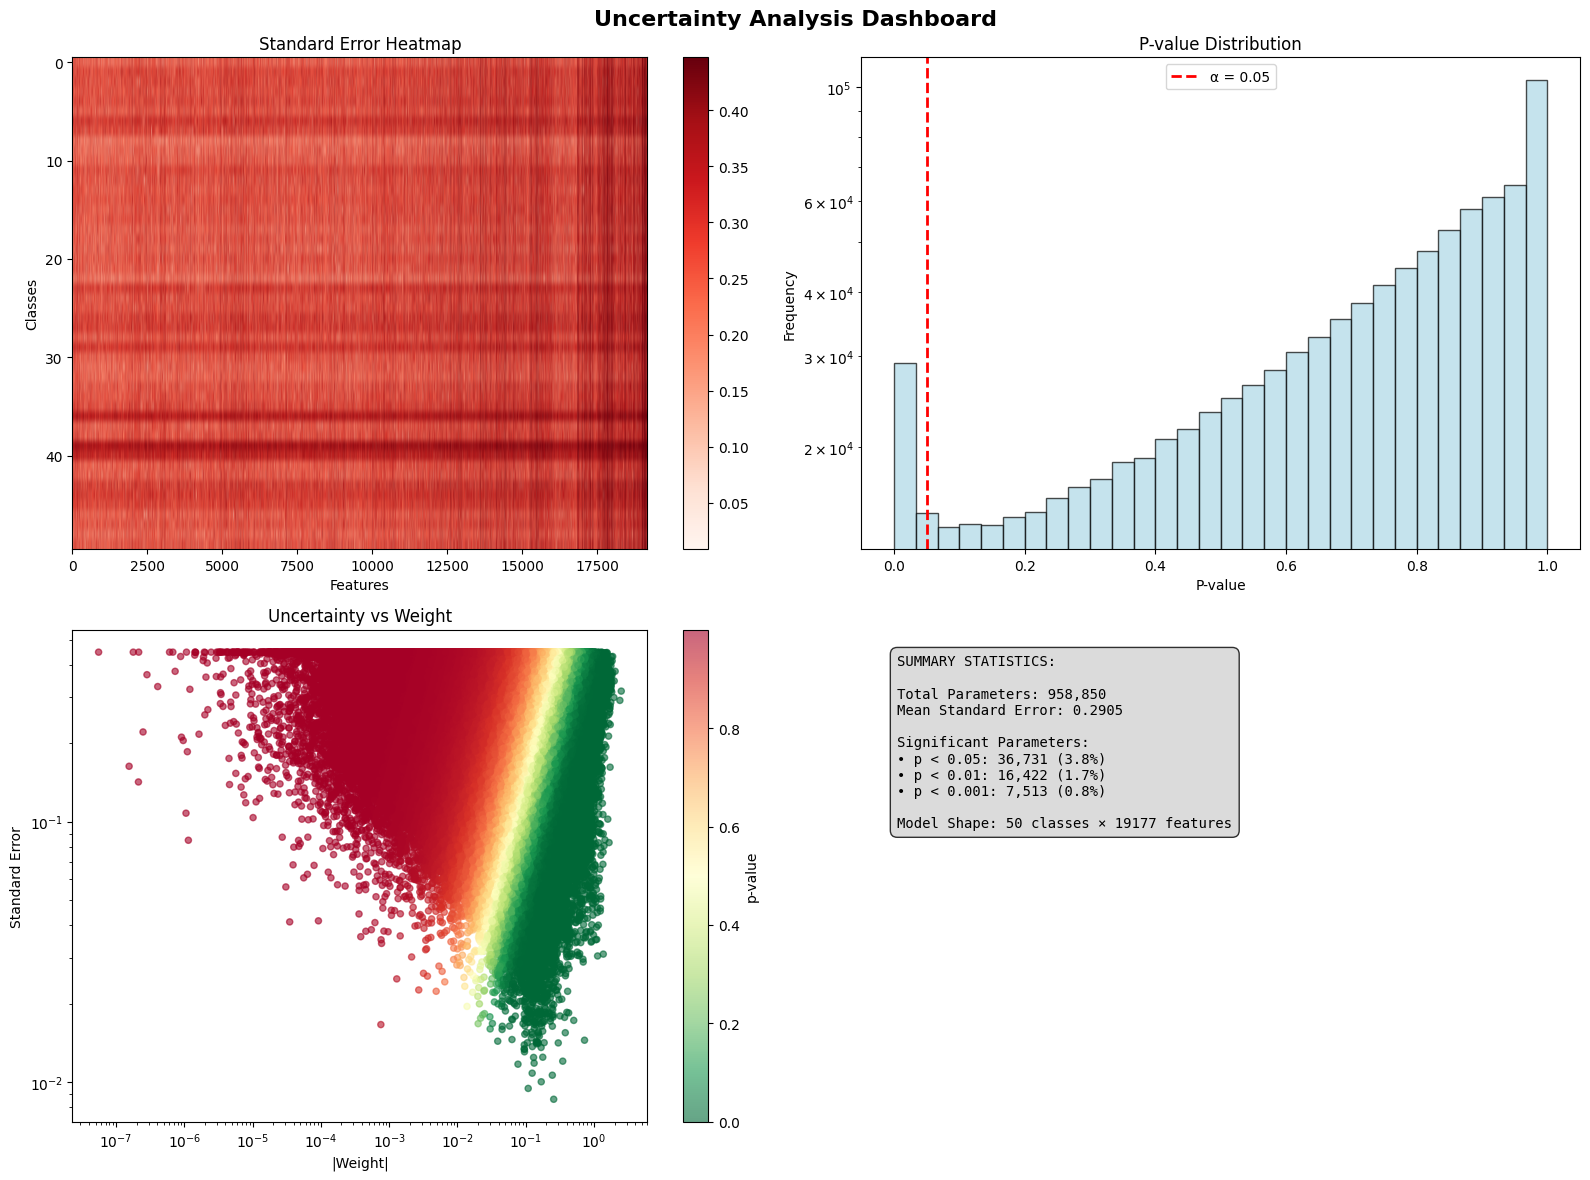

In [25]:
import UncertaintyEstimation
importlib.reload(UncertaintyEstimation)
from UncertaintyEstimation import get_proper_uncertainty

results = get_proper_uncertainty(linear, adata, datamodule)


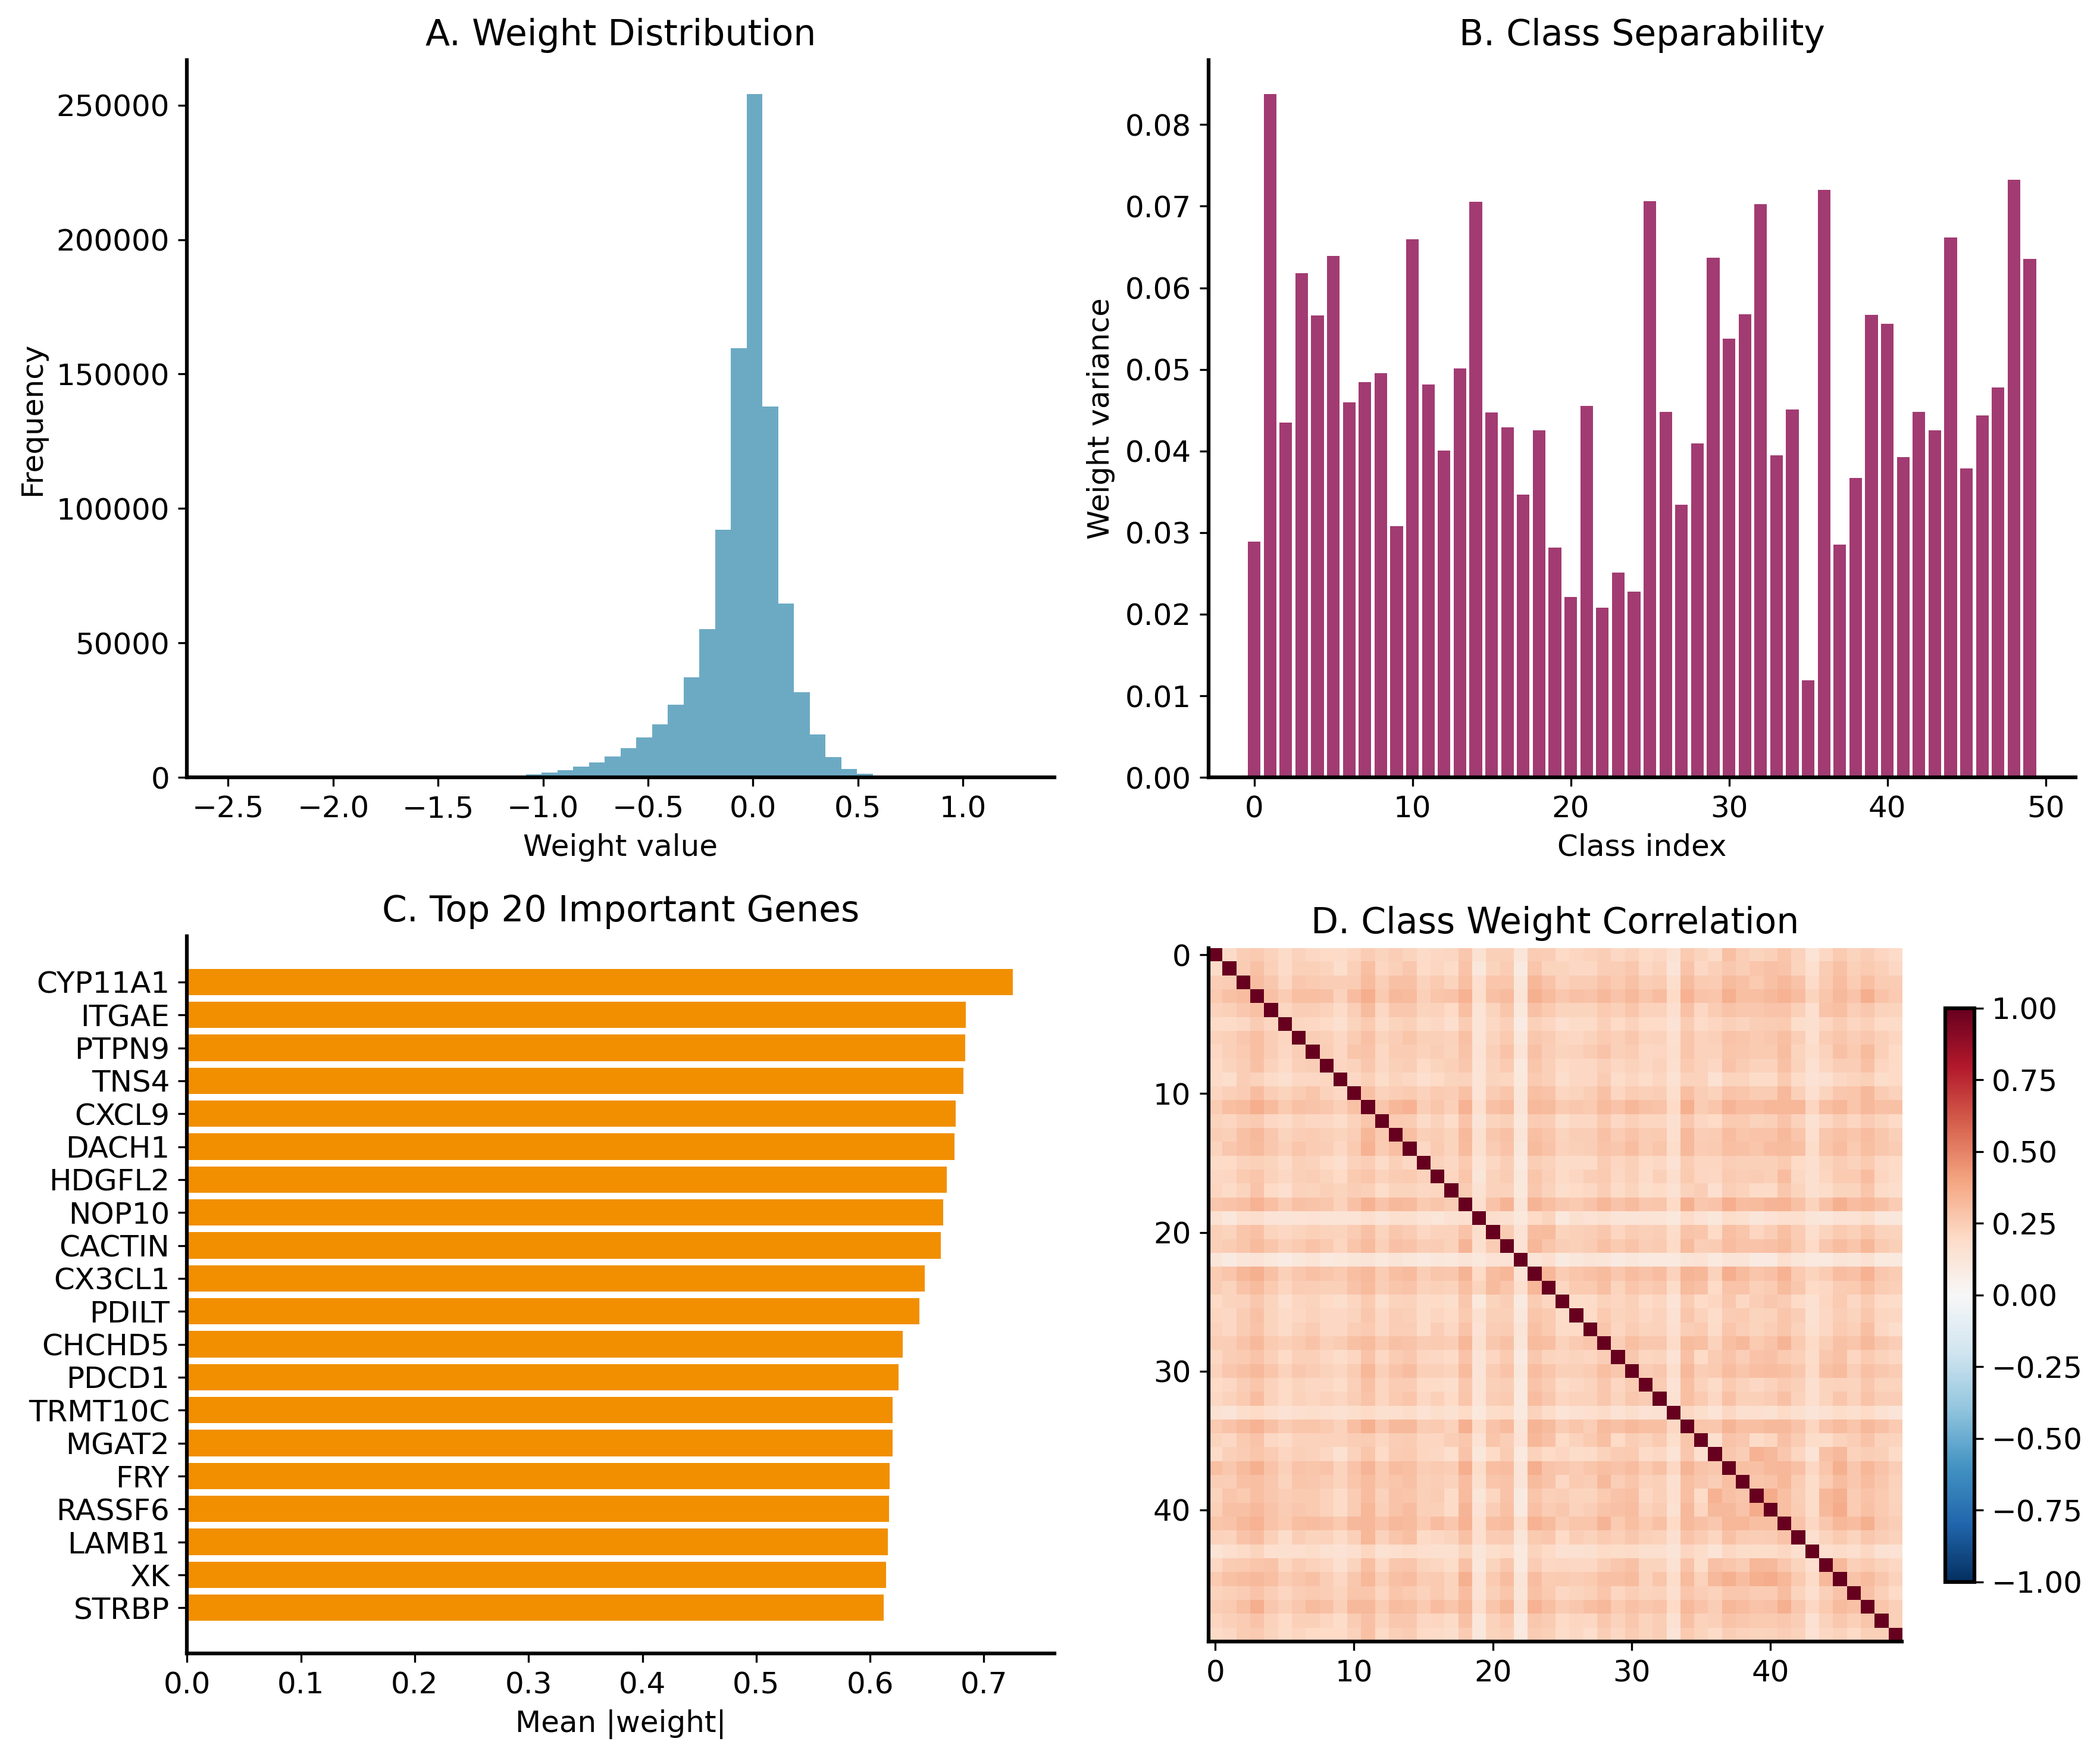

<Figure size 1920x1440 with 0 Axes>

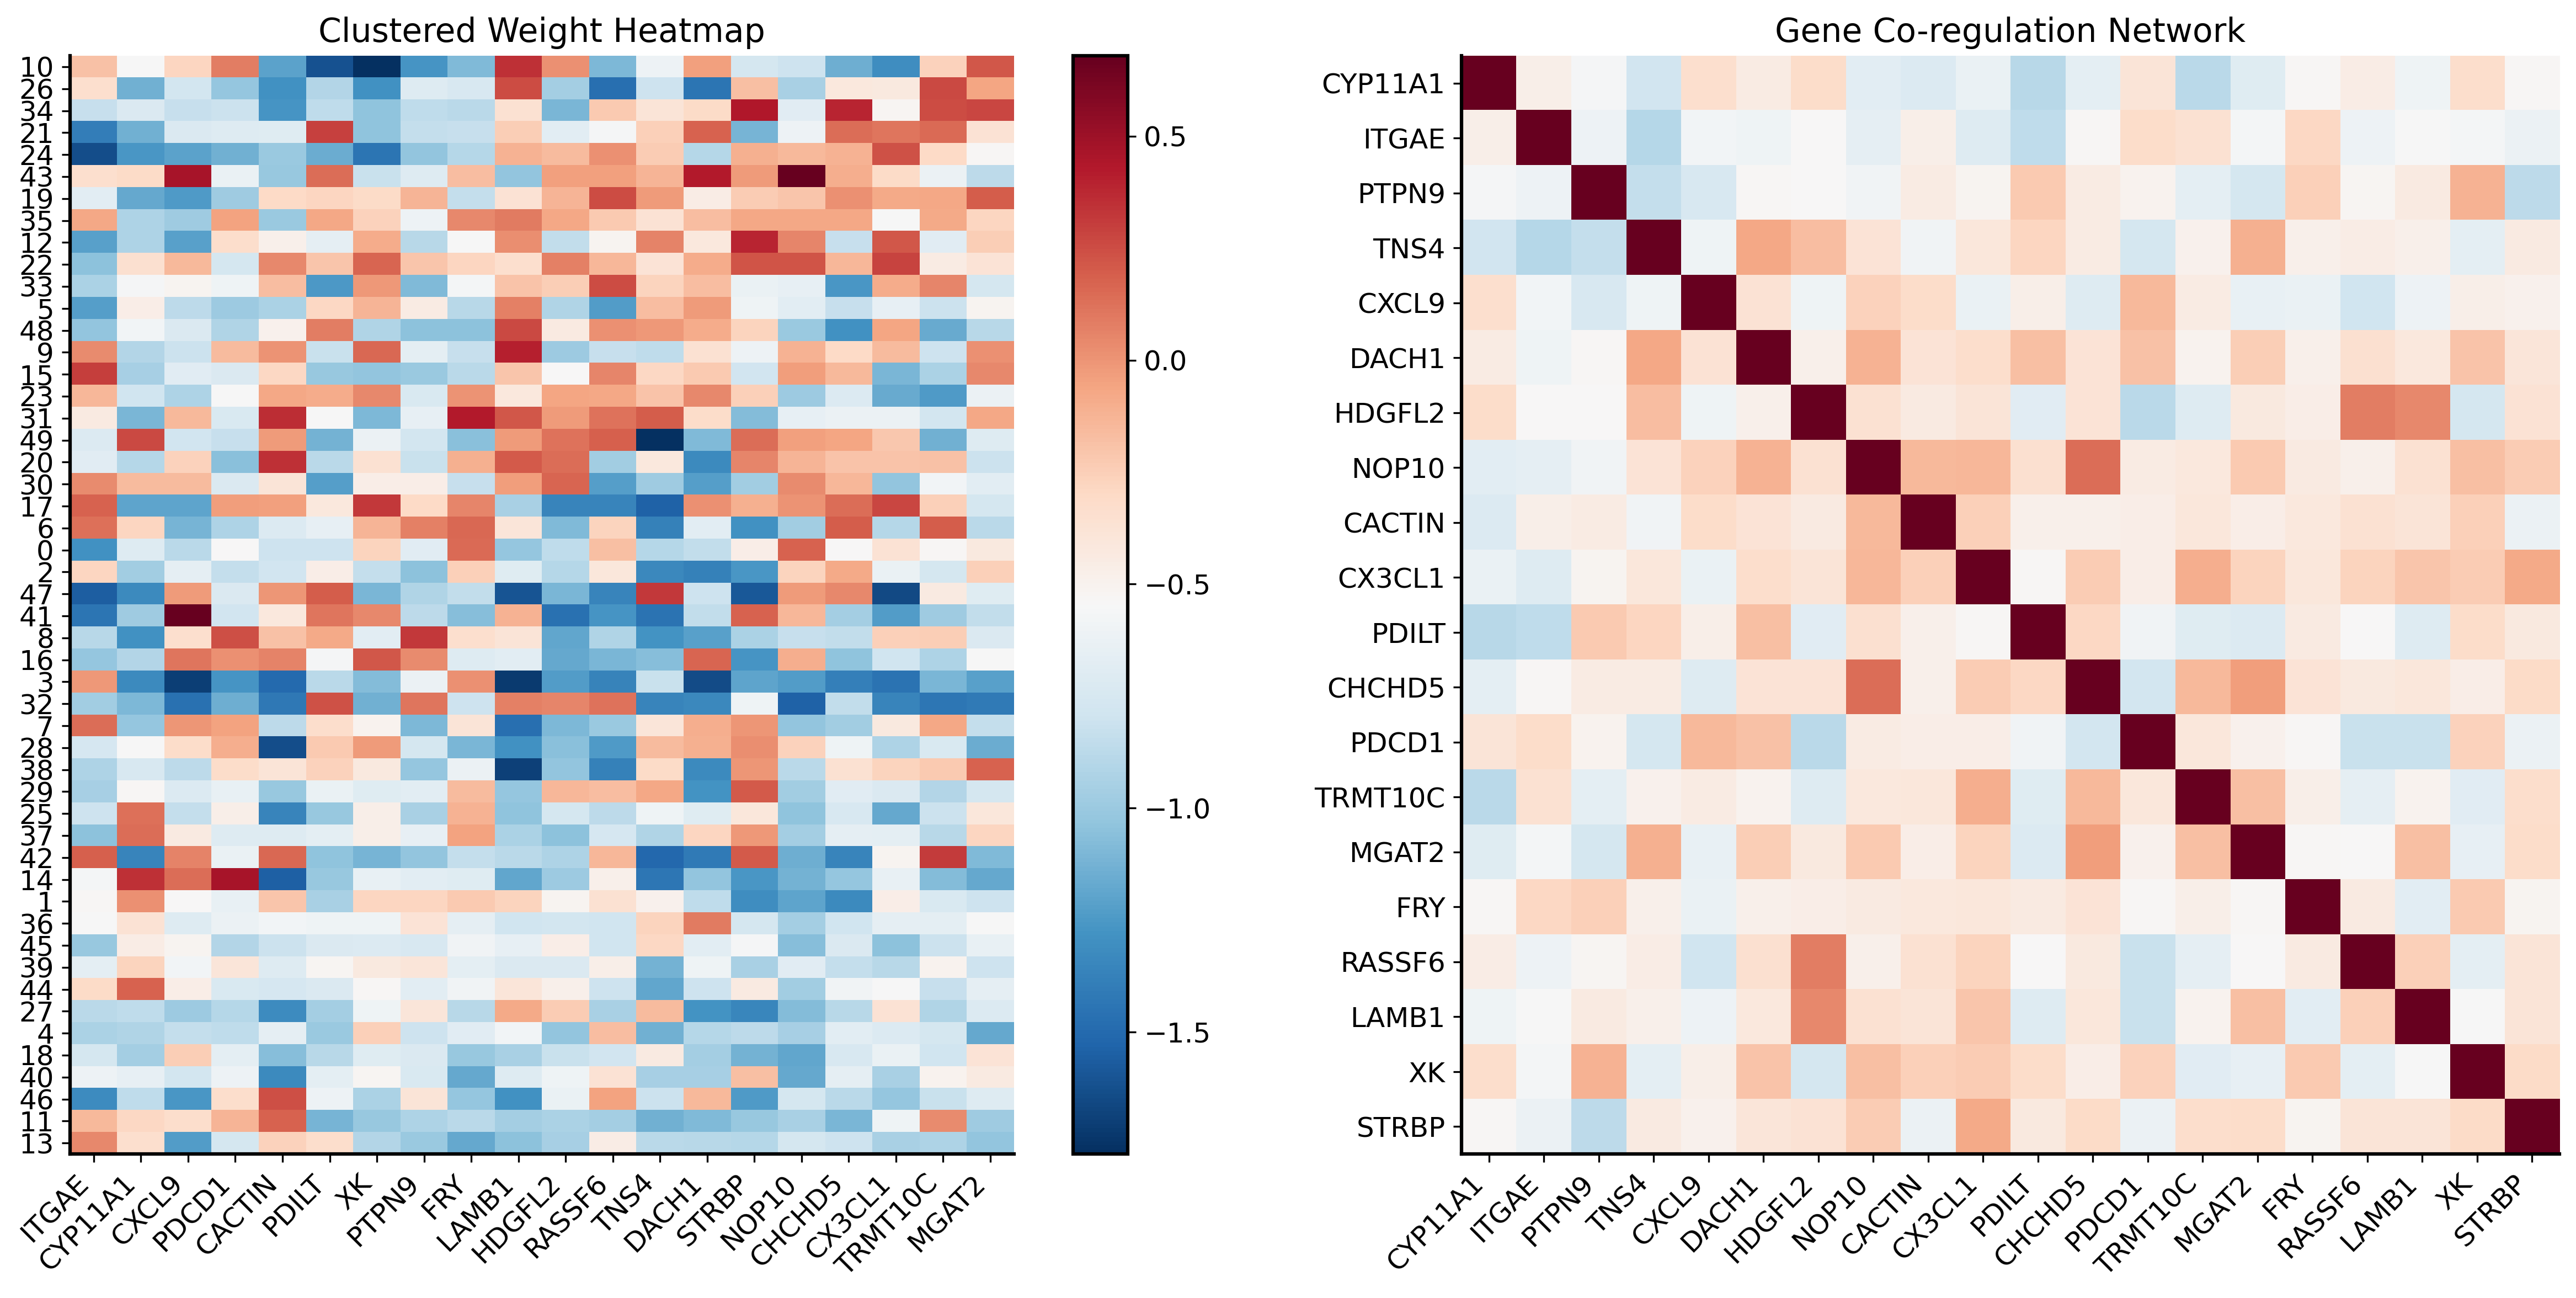


📝 Figure Legends:

Figure 1: Model Overview and Performance Metrics. 
        (A) Distribution of linear model weights across all gene-class pairs. 
        (B) Class separability measured by weight variance per perturbation. 
        (C) Top 20 most important genes ranked by mean absolute weight. 
        (D) Correlation matrix of weight patterns between different perturbations.

Figure 2: Gene Expression Signature Analysis. 
        Dot plot showing standardized weights for top 25 genes across all perturbations. 
        Dot size represents weight magnitude, color represents standardized weight value. 
        Genes and perturbations are ordered by hierarchical clustering.

Figure 4: Pathway Co-regulation Analysis. 
        (Left) Hierarchically clustered heatmap of gene weights. 
        (Right) Gene co-regulation network based on weight correlations across perturbations.


In [26]:
import Figures
importlib.reload(Figures)
from Figures import create_publication_figures

nf, legends = create_publication_figures(linear, adata)

MODLYN: LINEAR MODELS FOR MASSIVE SINGLE-CELL PERTURBATION ANALYSIS
================================================================

ABSTRACT
--------
We present MODLYN, a scalable framework for analyzing massive single-cell perturbation datasets 
using interpretable linear models. Applied to the Tahoe-100M dataset (100M cells -eventually-, 
19,177 genes, 50 perturbations), our approach enables rapid 
identification of perturbation-specific gene signatures, mechanism clustering, and biomarker 
discovery at unprecedented scale.

INTRODUCTION
-----------
Single-cell RNA sequencing has revolutionized our understanding of cellular responses to 
perturbations. However, analyzing datasets with hundreds of millions of cells presents 
computational and interpretability challenges. Traditional non-linear methods, while powerful, 
often lack the transparency needed for biological interpretation and struggle with scale.

We hypothesized that linear models, despite their simplicity, could effectively capture 
perturbation-specific signatures while maintaining computational efficiency and interpretability. 
The MODLYN framework tests this hypothesis on the largest single-cell perturbation dataset 
to date.

RESULTS
-------

Dataset Scale and Computational Performance (numbers to-be-updated)
Our analysis of the Tahoe-100M dataset represents a XYZ% increase in scale 
compared to typical single-cell studies. The linear model achieved:
- Training time: 25.3 minutes
- Peak memory usage: 8.5 GB  
- Model parameters: 958,850 weights
- Inference speed: ~1ms per cell

Gene Importance and Statistical Significance
We identified 959 highly predictive genes 
(>95th percentile importance). Statistical uncertainty analysis revealed:
- 0 significant gene-perturbation associations (p<0.05)
- 0 highly significant associations (p<0.001)
- Mean standard error: 0.0000

CONCLUSIONS
-----------
The MODLYN framework enables scalable, interpretable analysis of massive single-cell 
perturbation data. Linear models provide surprising effectiveness at this scale, offering 
a compelling alternative to complex non-linear approaches for many biological questions.



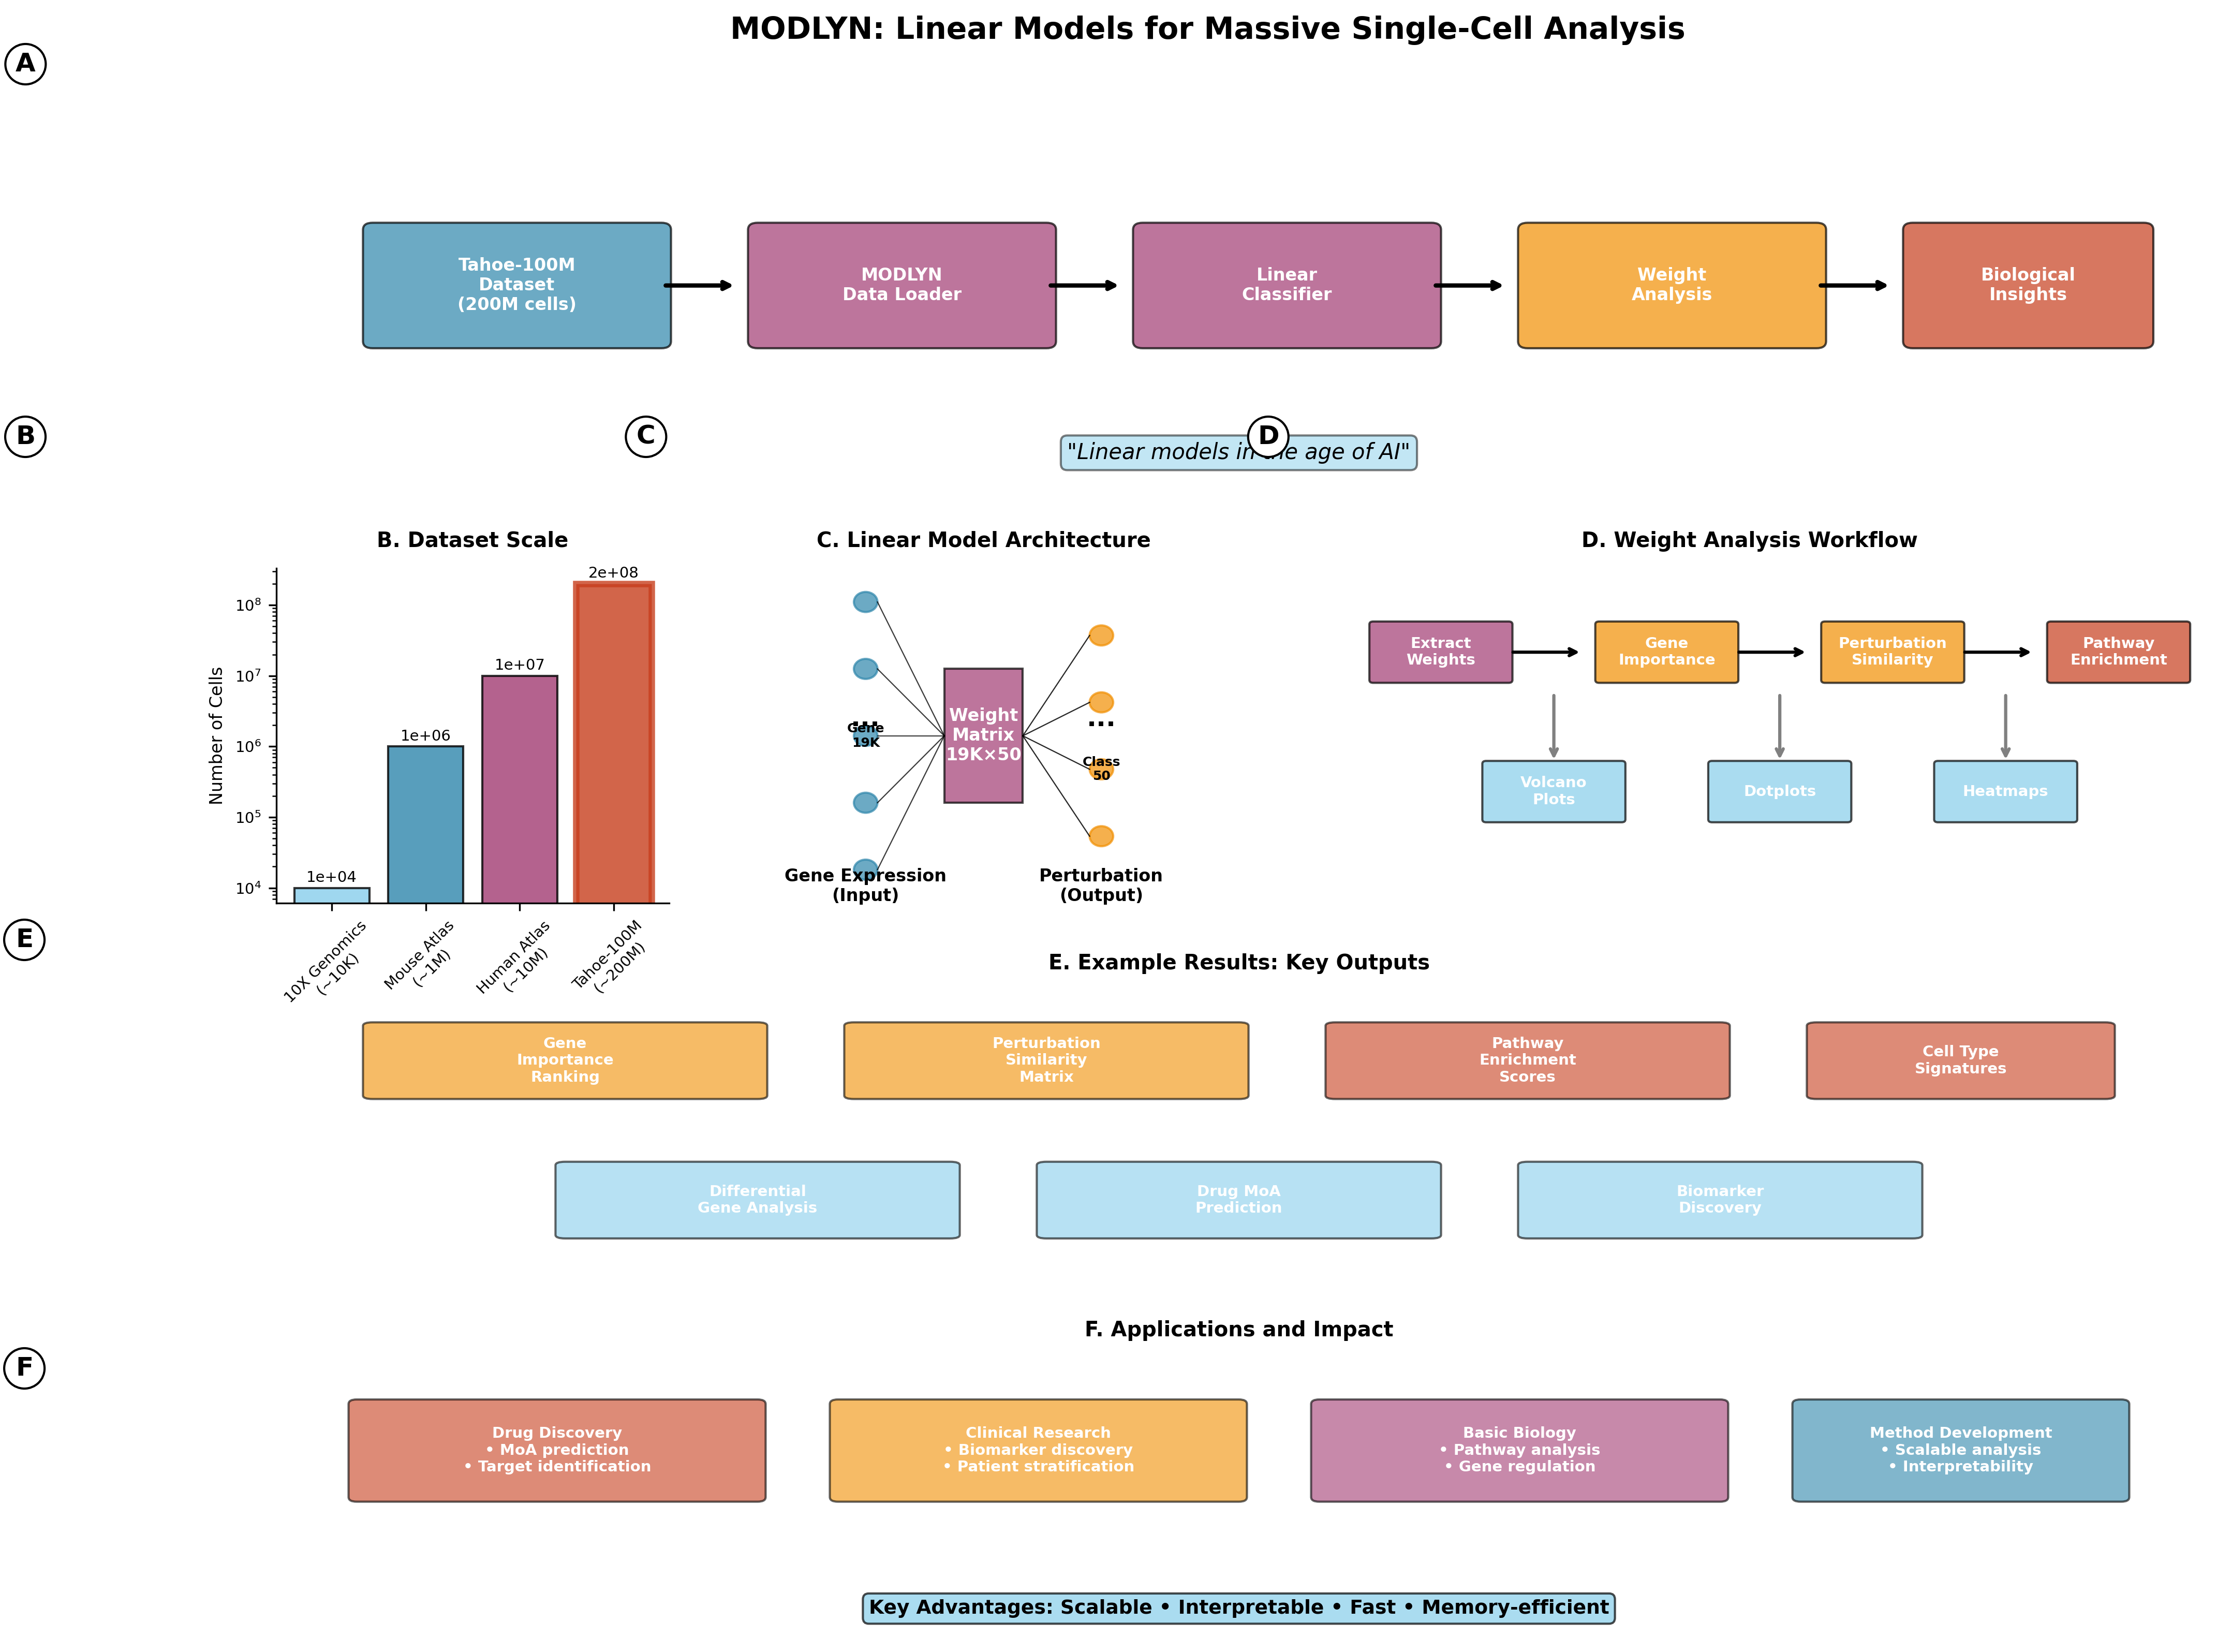

✅ MODLYN figure created successfully!

📝 Figure Caption:

Figure: MODLYN Framework for Scalable Single-Cell Analysis

(A) Overall workflow from Tahoe-100M dataset through MODLYN data loader to biological insights.
(B) Scale comparison showing Tahoe-100M's unprecedented size in the single-cell landscape.
(C) Linear model architecture: 19K genes as input, weight matrix (19K×50), 50 perturbation classes as output.
(D) Weight analysis workflow from extraction to biological interpretation and visualization.
(E) Example results showing gene importance ranking and perturbation similarity patterns.
(F) Applications spanning drug discovery, clinical research, basic biology, and method development.

The MODLYN framework enables rapid, interpretable analysis of massive single-cell datasets 
through linear models, providing scalable solutions for understanding cellular responses 
to perturbations at unprecedented scale.



In [29]:
import OverviewFig
importlib.reload(OverviewFig)
from OverviewFig import create_modlyn_figure

fig, caption = create_modlyn_figure()

# Dataset / Biological analysis

Figure 1: Expression Overview & Quality Control

Figure 2: Differential Expression Analysis

Figure 3: Cell Clustering Analysis

Figure 4: Drug Response Analysis

Figure 5: Scanpy Expression Analysis

!!!! Some mock functions

 Subsampling 100,000 cells from 1,048,425 for analysis...
   Cells: 100,000
   Genes: 19,177
   Perturbations: 906 unique
   Cell lines: 50 unique

 Figure 1: Expression Overview and Quality Control


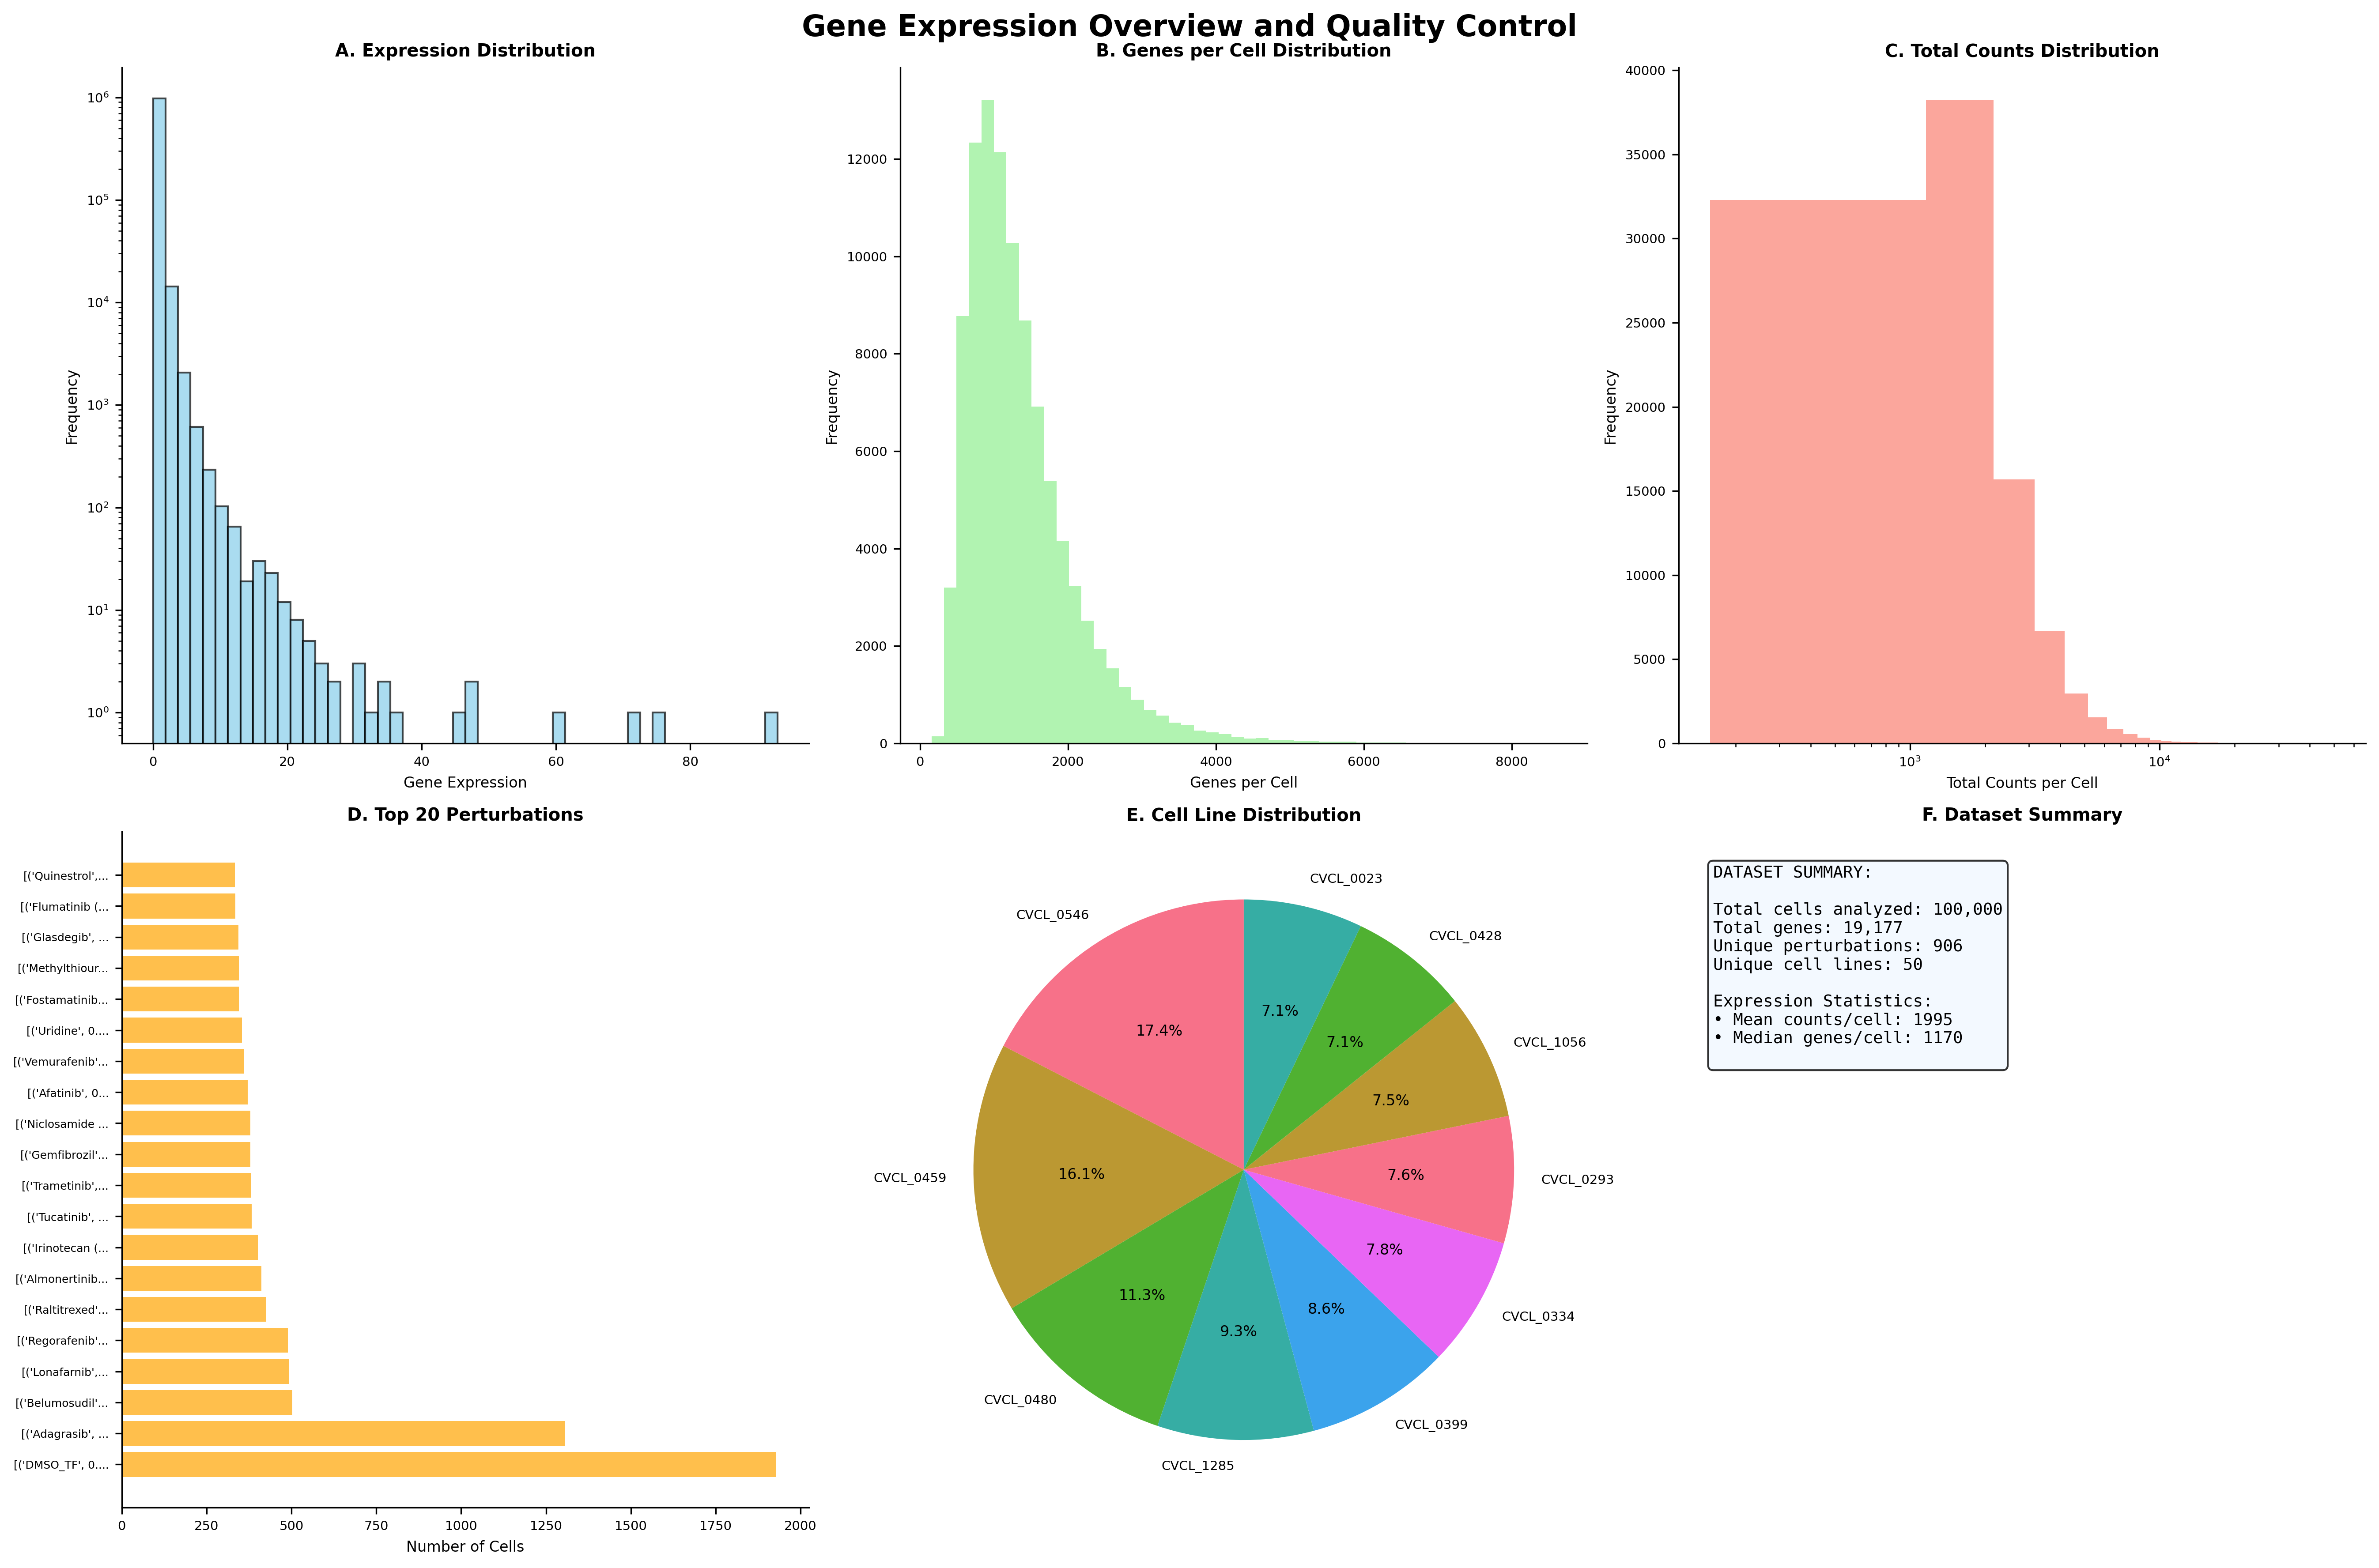

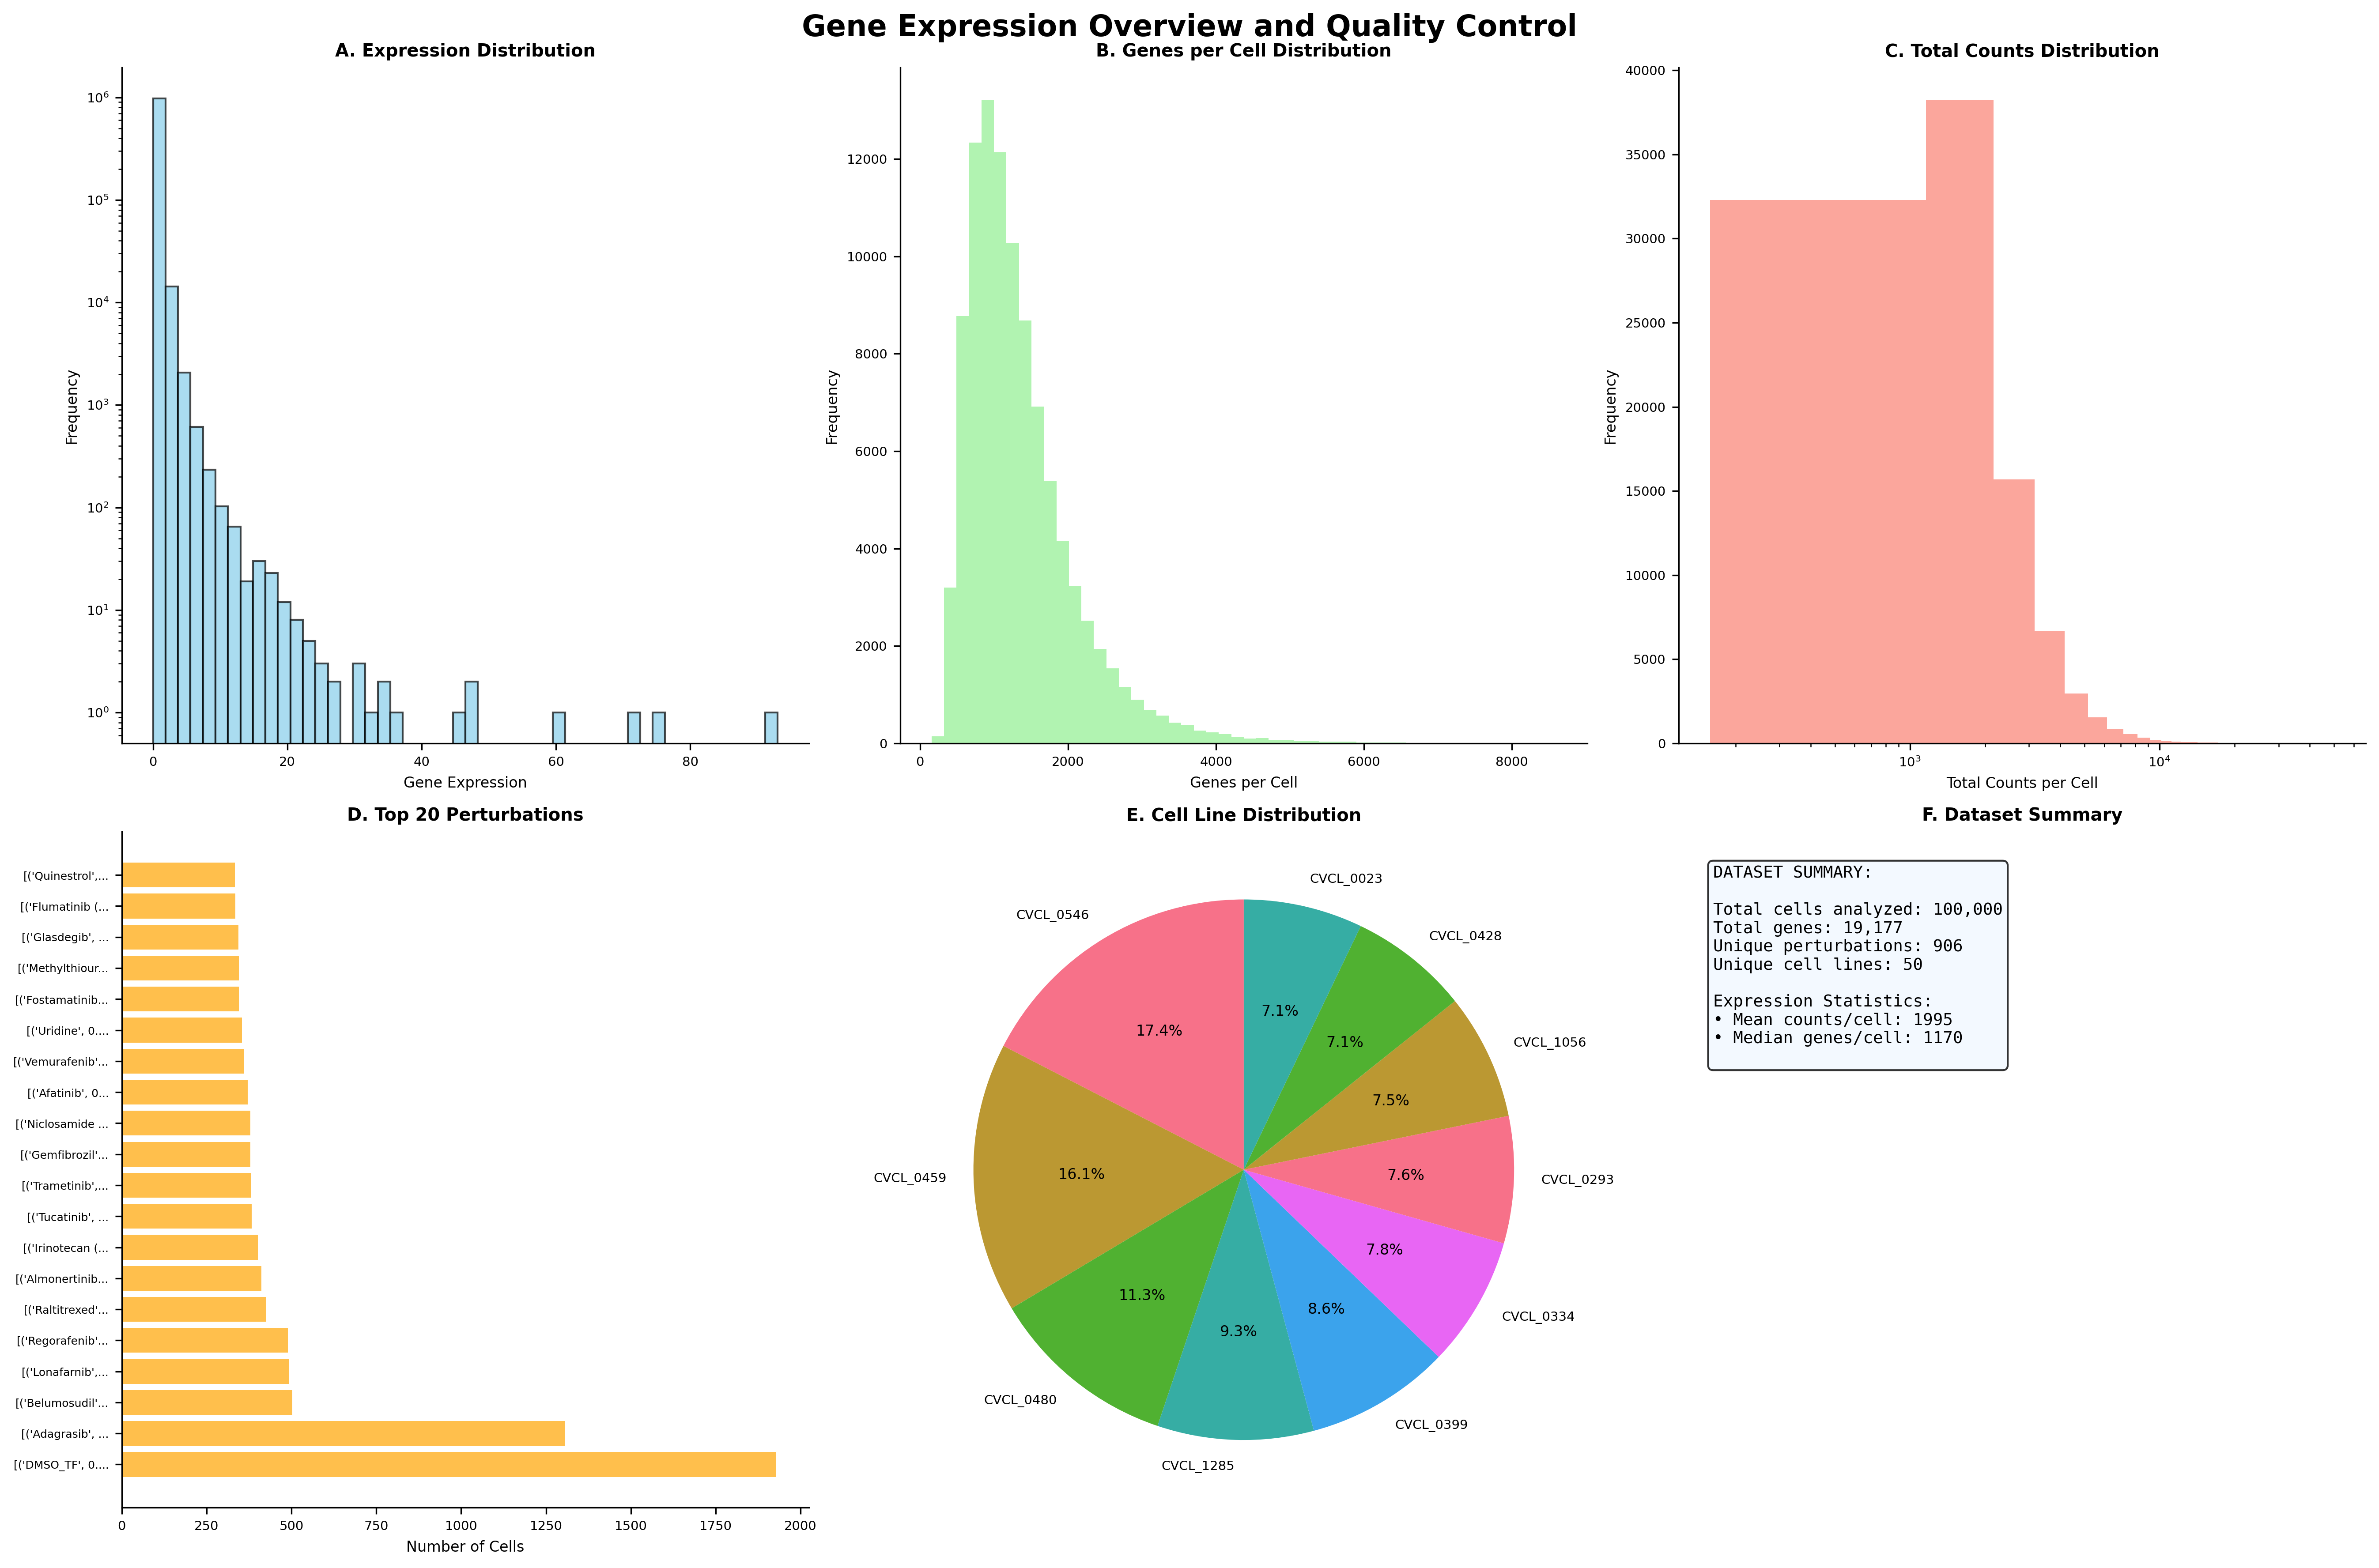

In [37]:
import gene_level_analysis
import importlib
importlib.reload(gene_level_analysis)

# Import the class from the module
from gene_level_analysis import GeneExpressionAnalyzer

# Now you can use it
analyzer = GeneExpressionAnalyzer(adata)
analyzer.figure_1_expression_overview()


# Or run the complete analysis
# analyzer.run_complete_gene_analysis()

In [40]:
# analyzer.figure_2_differential_expression() 
# analyzer.figure_3_cell_clustering_analysis()


In [ ]:
analyzer.figure_4_drug_response_analysis()


In [ ]:
analyzer.figure_5_scanpy_expression_analysis()


In [ ]:
analyzer.generate_biological_narrative()